In [1]:
!nvidia-smi

Fri Dec 22 11:39:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           On  | 00000000:06:00.0 Off |                    0 |
| N/A   35C    P0              71W / 300W |      3MiB / 16384MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

# %cd PROTES

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
# !pip install -r requirements.txt
# !pip install transformers

In [1]:
import math

import jax
jax.config.update('jax_enable_x64', True)
import numpy as np
import torch
from torch.nn.functional import softmax, log_softmax
from torch.optim import AdamW
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.notebook import tqdm

from protes import protes_gpt, protes

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# Creating something

In [2]:
softmax = torch.nn.Softmax(dim=-1)
logsoftmax = torch.nn.LogSoftmax(dim=-1)

In [37]:
def custom_nll_loss(probs, I):
    """
    probs: 1 x (1 + d) x n logsoftmax of logits
    I:      1 x (1 + d)
    where 1 is added becaus of SOS token in the beggining
    how to deal with bs > 1 properly i don't understand so far
    """
    loss = 0

    bs, seq_len, _ = probs.shape
    P = probs
    for j in range(bs):
        for i in range(1, seq_len):   # for i in range(1, seq_len):
            loss += P[j, i, I[j, i]] 

    loss = torch.sum(loss, dim=0)
    return -loss



#     scores = model.compute_transition_scores(
#                 sequences=outputs.sequences,
#                 scores=outputs.scores,
#             )
#     loss = scores[idx][:, -1].mean()

In [38]:
def trainer(model, func, d, m, k, k_top, is_max, n):

    best_func_value = -torch.inf if is_max else torch.inf
    best_idx = None

    prompt = torch.tensor([[n + 1]]).to(device)
    
    for i in tqdm(range(math.ceil(m / k))):
        outputs =  model.generate(
            prompt,
            attention_mask=torch.ones_like(prompt), # torch.ones_like(prompt).to(device), torch.tril(torch.ones(1, d)).to(device)
            max_new_tokens=d,

            do_sample=True,
            num_beams=1,
            num_return_sequences=k,
            top_k=0,
            temperature=0.5,
            length_penalty=0,

            output_scores=True,
            return_dict_in_generate=True, 
            renormalize_logits=True, 
            output_hidden_states=True,
            
            pad_token_id=n+2,
            eos_token_id=n+2,
            bos_token_id=n+1,
        )
        I = outputs.sequences
        
        calculated_f = func(I[:, 1:])
        val, idx = torch.topk(calculated_f.squeeze(), largest=is_max, k=1)

#         print(val)
        

        if is_max and (val > best_func_value):
            best_func_value = val
            best_idx = I[idx, 1:]
        
        if not is_max and (val < best_func_value):
            best_func_value = val
            best_idx = I[idx, 1:]
        
        _, idxes = torch.topk(calculated_f.squeeze(), largest=is_max, k=k_top)
        batch_of_best_I = I[idxes] ### ??? [idxes, 1:]
        
        optimizer.zero_grad()
        logits = model.forward(batch_of_best_I, attention_mask=torch.ones_like(batch_of_best_I)).logits
        
#         logits = model(batch_of_best_I, attention_mask=torch.tril(torch.ones_like(batch_of_best_I))).logits
        logits = logsoftmax(logits)
        
        loss = criterion(logits, batch_of_best_I)
        loss.backward()

        optimizer.step()

        if i % 10 == 0:
            print('batch {} loss: {} best_value {}'.format(i, loss.item(), best_func_value.item()))
    

    return best_func_value, best_idx, model, logits

## Simple delta-functions

In [39]:
a = -3
b = 3

n = 1000 #50257 #len(tokenizer)
d = 1

m = 200_000
k = 512
k_top = 128
is_max = True
log = True


beta = torch.tensor([0.1]).to("cuda:0")

def f_simple(I):
#     I = (I - 1) / (n) * (b - a) + a
    I = I / (n - 1) * (b - a) + a
    f = torch.exp(- (I[:, :] - 1) ** 2 / beta ** 2) / torch.sqrt(torch.pi * torch.abs(beta))
    return f


func = f_simple

In [107]:
xs = np.linspace(a, b, n)
f = f_simple(torch.tensor(np.arange(0, n).reshape(-1, 1)).to("cuda:0"))

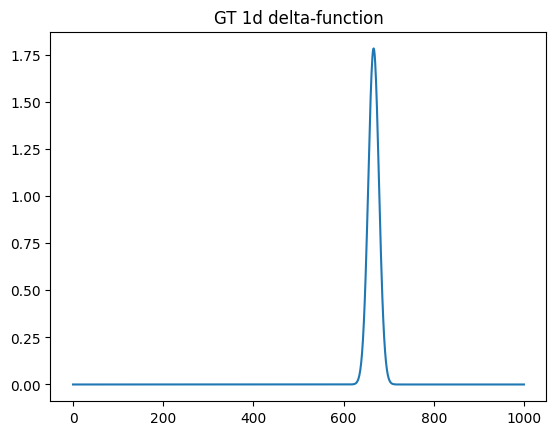

In [110]:
plt.plot(np.arange(0, n), f.cpu())
plt.title("GT 1d delta-function")
plt.show()

In [42]:
# model = AutoModelForCausalLM.from_pretrained("gpt2", bos_token_id=n+1, pad_token_id=n+2).to(device)
model = AutoModelForCausalLM.from_pretrained("gpt2", bos_token_id=n+1, pad_token_id=n+2).to(device)
model.resize_token_embeddings(n + 2)
model.train()


model.config.bos_token_id = n + 1
model.config.pad_token_id = n + 2
model.config.eos_token_id = n + 2

model.generation_config.bos_token_id = n + 1
model.generation_config.pad_token_id = n + 2
model.generation_config.eos_token_id = n + 2


optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = custom_nll_loss

best_func_value, best_idx, model, outputs = trainer(model=model, func=func, d=d, m=m, k=k, k_top=k_top, is_max=is_max, n=n)

print(f"PROTES_GPT: i_opt = {best_idx}, x_opt = {(best_idx) / (n-1) * (b-a) + a} f_opt = {best_func_value}")

  0%|          | 0/391 [00:00<?, ?it/s]

batch 0 loss: 1078.2987060546875 best_value 1.0612914562225342
batch 10 loss: 345.7694091796875 best_value 1.6302706003189087
batch 20 loss: 5.109002113342285 best_value 1.7841241359710693
batch 30 loss: 1.4002851247787476 best_value 1.7841241359710693
batch 40 loss: 0.1674259752035141 best_value 1.7841241359710693
batch 50 loss: 0.22096899151802063 best_value 1.7841241359710693
batch 60 loss: 0.14122389256954193 best_value 1.7841241359710693
batch 70 loss: 0.451621949672699 best_value 1.7841241359710693
batch 80 loss: 2.2368874549865723 best_value 1.7841241359710693
batch 90 loss: 0.5058247447013855 best_value 1.7841241359710693
batch 100 loss: 0.10934137552976608 best_value 1.7841241359710693
batch 110 loss: 0.9447064995765686 best_value 1.7841241359710693
batch 120 loss: 0.35570377111434937 best_value 1.7841241359710693
batch 130 loss: 0.050943367183208466 best_value 1.7841241359710693
batch 140 loss: 0.06148308515548706 best_value 1.7841241359710693
batch 150 loss: 0.14811764657497

In [45]:
print(torch.exp(outputs[:, 1, :n]).sum())

tensor(128., device='cuda:0', grad_fn=<SumBackward0>)


In [59]:
outputs.shape

torch.Size([128, 2, 1002])

torch.Size([128, 1002])


Text(0.5, 1.0, 'Argmax 620')

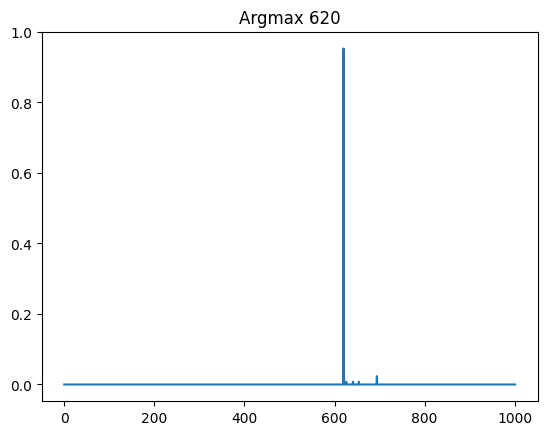

In [65]:
PPs = torch.exp(outputs[:, 1, :n+2])
print(PPs.shape)
dist = PPs.mean(dim=0).cpu().detach().numpy()
plt.plot(dist)
plt.title(f"Argmax {dist.argmax()}")

torch.Size([128, 1002])


Text(0.5, 1.0, 'Argmax 694')

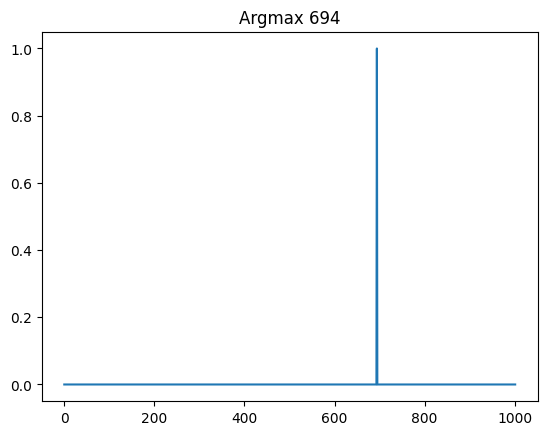

In [69]:
PPs = torch.exp(outputs[:, 1, :n+2])
print(PPs.shape)
dist = PPs[2].cpu().detach().numpy()
plt.plot(dist)
plt.title(f"Argmax {dist.argmax()}")

## Simple 2d delta-function

In [70]:
a = -3
b = 3

n = 1001 #50257 #len(tokenizer)
d = 2

m = 600_000
k = 1024
k_top = 256
is_max = True
log = True


beta = torch.tensor([0.1]).to("cuda:0")

def f_simple(I):
#     I = (I - 1) / (n) * (b - a) + a
    I = I / (n - 1) * (b - a) + a
    f = torch.exp(- ((I[:, 0] - 1) ** 2 +  (I[:, 1] - 2) ** 2)/ beta ** 2 ) / torch.sqrt(torch.pi * torch.abs(beta))
    return f


func = f_simple

In [71]:
# model = AutoModelForCausalLM.from_pretrained("gpt2", bos_token_id=n+1, pad_token_id=n+2).to(device)
model = AutoModelForCausalLM.from_pretrained("gpt2", bos_token_id=n+1, pad_token_id=n+2).to(device)
model.resize_token_embeddings(n + 2)
model.train()


model.config.bos_token_id = n + 1
model.config.pad_token_id = n + 2
model.config.eos_token_id = n + 2

model.generation_config.bos_token_id = n + 1
model.generation_config.pad_token_id = n + 2
model.generation_config.eos_token_id = n + 2


optimizer = AdamW(model.parameters(), lr=1e-9)
criterion = custom_nll_loss

best_func_value, best_idx, model, outputs = trainer(model=model, func=func, d=d, m=m, k=k, k_top=k_top, is_max=is_max, n=n)

print(f"PROTES_GPT: i_opt = {best_idx}, x_opt = {(best_idx) / (n-1) * (b-a) + a} f_opt = {best_func_value}")

  0%|          | 0/586 [00:00<?, ?it/s]

batch 0 loss: 4268.4130859375 best_value 0.0
batch 10 loss: 4387.341796875 best_value 0.0002602481108624488
batch 20 loss: 4331.23046875 best_value 0.0002602481108624488
batch 30 loss: 4351.5126953125 best_value 1.549182415008545
batch 40 loss: 4290.86279296875 best_value 1.549182415008545
batch 50 loss: 4355.0029296875 best_value 1.549182415008545
batch 60 loss: 4379.6826171875 best_value 1.549182415008545
batch 70 loss: 4342.18359375 best_value 1.549182415008545
batch 80 loss: 4414.9833984375 best_value 1.549182415008545
batch 90 loss: 4364.470703125 best_value 1.549182415008545
batch 100 loss: 4253.56640625 best_value 1.549182415008545
batch 110 loss: 4275.1953125 best_value 1.549182415008545
batch 120 loss: 4312.298828125 best_value 1.549182415008545
batch 130 loss: 4429.5166015625 best_value 1.549182415008545
batch 140 loss: 4289.32373046875 best_value 1.549182415008545
batch 150 loss: 4257.1845703125 best_value 1.549182415008545
batch 160 loss: 4366.0439453125 best_value 1.549182

In [72]:
# I = torch.tensor([
#     [1, 2]
# ]).to("cuda:0")


I = torch.tensor([
    [667, 834]
]).to("cuda:0")
I = I / (n - 1) * (b - a) + a
print(I)

torch.exp(- ((I[:, 0] - 1) ** 2 +  (I[:, 1] - 2) ** 2)/ beta ** 2 ) / torch.sqrt(torch.pi * torch.abs(beta))

tensor([[1.0020, 2.0040]], device='cuda:0')


tensor([1.7806], device='cuda:0')

In [74]:
outputs.shape

torch.Size([256, 3, 1003])

In [99]:
# xs = np.linspace(a, b, n)
# B, D = np.meshgrid(xs, xs)
# plt.contourf(B, D, nu)
# plt.colorbar()
# plt.xlabel('b')
# plt.ylabel('d')
# plt.show()

In [94]:
PPs_x = torch.exp(outputs[:, 1, :n+2]).mean(dim=0).cpu().detach()
PPs_y = torch.exp(outputs[:, 2, :n+2]).mean(dim=0).cpu().detach()
PPs = torch.outer(PPs_x, PPs_y)

In [95]:
PPs_x.shape

torch.Size([1003])

In [96]:
PPs_x.sum()

tensor(1.0000)

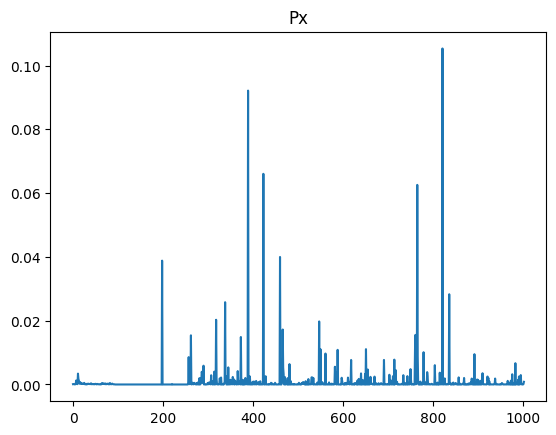

In [116]:
plt.plot(PPs_x)
plt.title("Px")
plt.show()

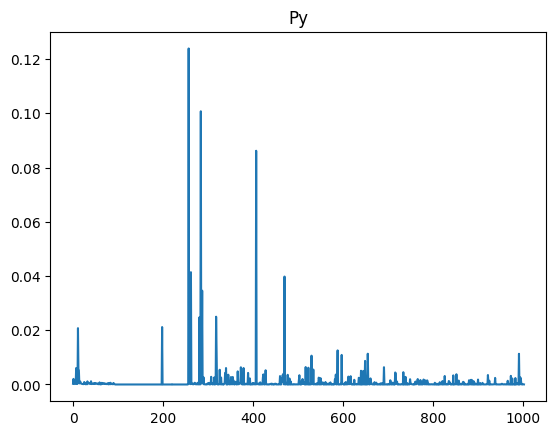

In [117]:
plt.plot(PPs_y.cpu())
plt.title("Py")
plt.show()

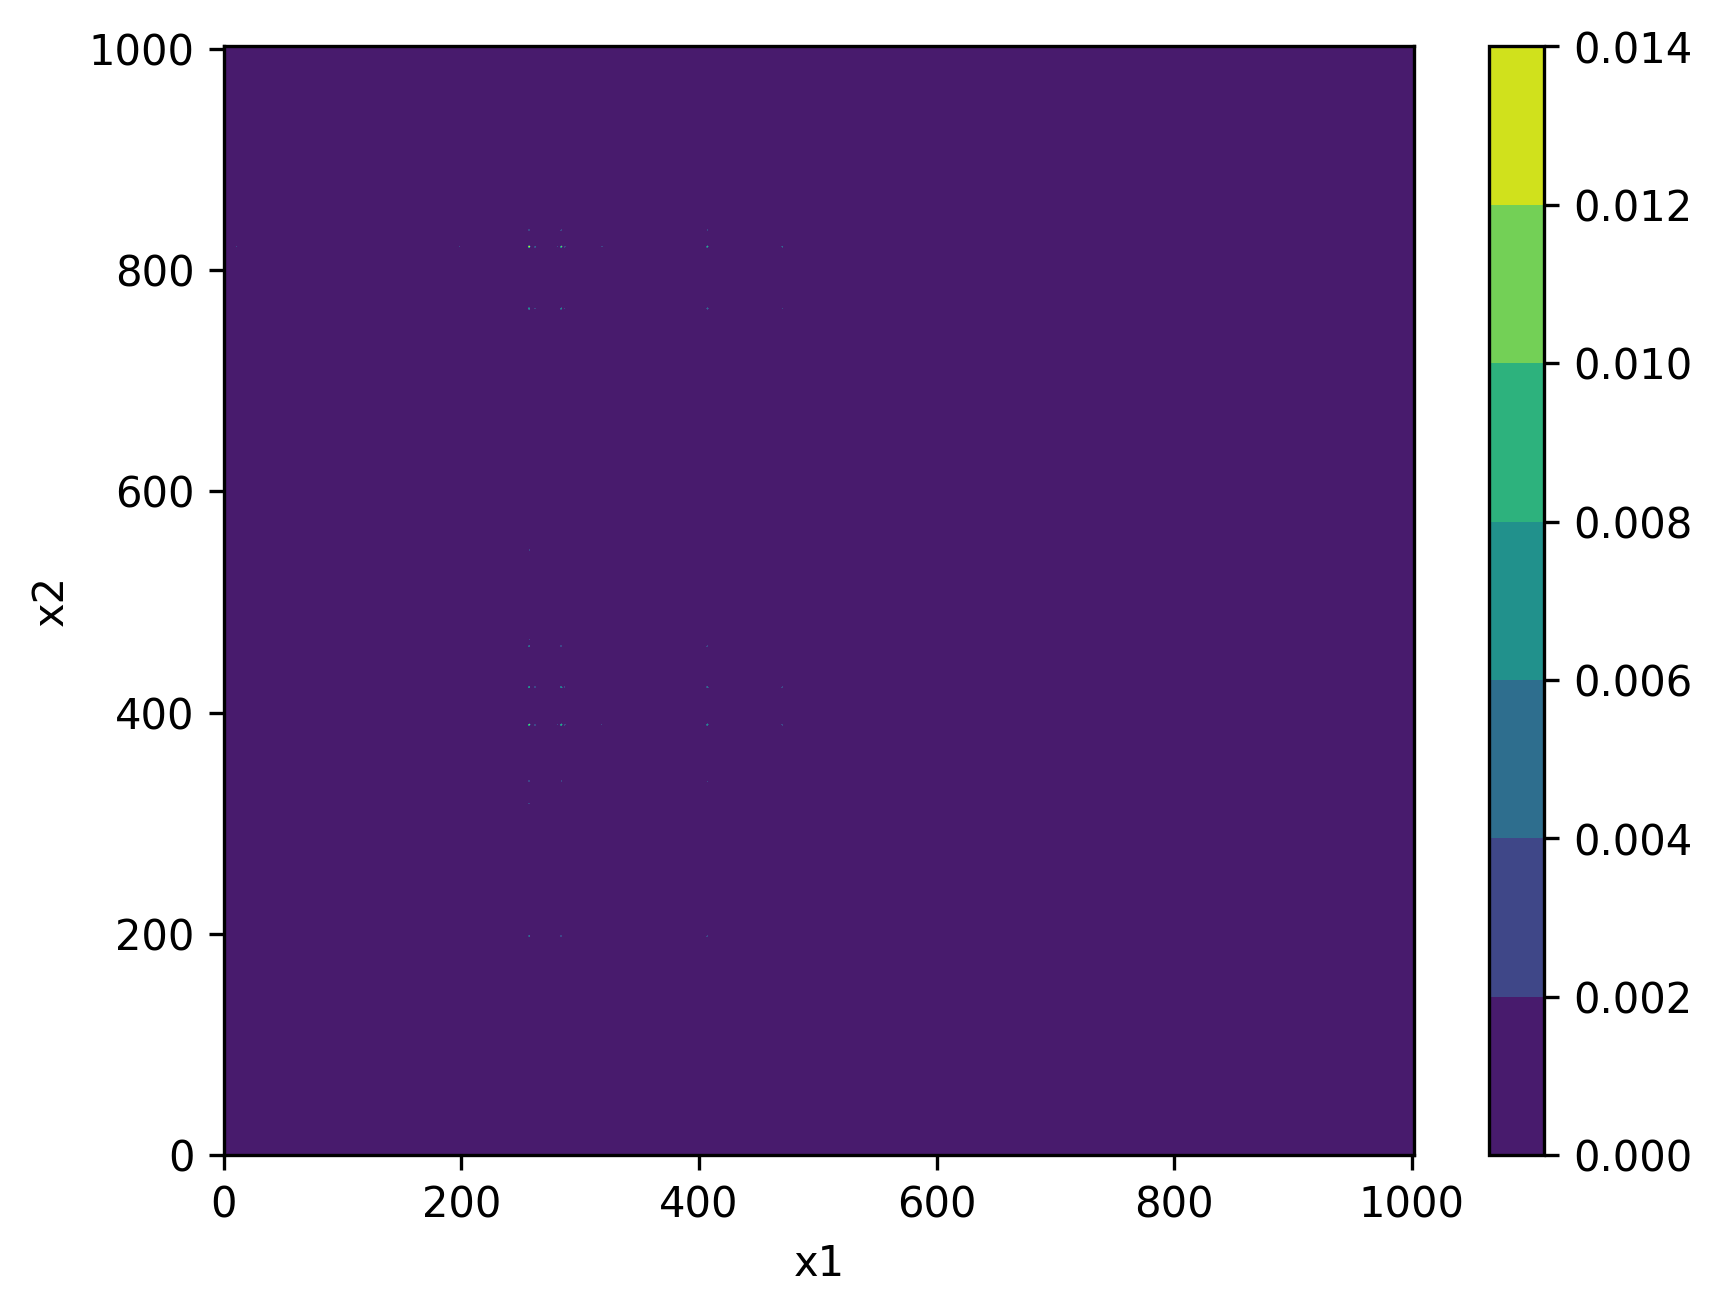

In [121]:
plt.figure(dpi=300)
plt.contourf(PPs.cpu())
plt.colorbar(cmap="grey")
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig("fig1.pdf")
plt.show()

In [27]:
PPs

(tensor([[-15.9031, -13.8535, -20.6170,  ..., -24.0271, -15.9628, -13.4543],
         [-17.1246, -18.2690, -25.3726,  ..., -28.3913, -18.3185, -16.5401],
         [-15.1332, -14.5951, -23.4702,  ..., -21.4286, -17.0911, -16.1156],
         ...,
         [-15.1531, -14.7714, -20.5292,  ..., -21.2355, -19.2516, -14.0850],
         [-18.1588, -16.5051, -23.3979,  ..., -20.8745, -16.0955, -14.5102],
         [ -8.4902,  -8.1386, -13.4718,  ..., -15.2941, -12.9932, -10.7383]],
        device='cuda:0'),
 tensor([[-17.8118, -19.1472, -26.3180,  ..., -30.7216, -23.6940, -25.1335],
         [-22.8397, -23.8037, -29.3727,  ..., -29.1212, -35.0991, -28.0738],
         [-16.9033, -17.7493, -26.1317,  ..., -25.3282, -27.7786, -22.6237],
         ...,
         [-17.8647, -17.8704, -25.8006,  ..., -28.4496, -28.5572, -22.5848],
         [-20.8544, -22.2271, -29.8303,  ..., -31.6359, -33.1249, -26.4340],
         [-15.2705, -15.3996, -18.3852,  ..., -24.8732, -10.4343, -13.4265]],
        device='cuda

In [ ]:
from transformers import GPT2Tokenizer, AutoModelForCausalLM
import numpy as np

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer.pad_token_id = tokenizer.eos_token_id
inputs = tokenizer(["Today is"], return_tensors="pt")

# Example 1: Print the scores for each token generated with Greedy Search
outputs = model.generate(**inputs, max_new_tokens=5, return_dict_in_generate=True, output_scores=True)
transition_scores = model.compute_transition_scores(
    outputs.sequences, outputs.scores, normalize_logits=True
)
# input_length is the length of the input prompt for decoder-only models, like the GPT family, and 1 for
# encoder-decoder models, like BART or T5.
input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]
generated_tokens = outputs.sequences[:, input_length:]
for tok, score in zip(generated_tokens[0], transition_scores[0]):
    # | token | token string | logits | probability
    print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.3f} | {np.exp(score.numpy()):.2%}")

# Example 2: Reconstruct the sequence scores from Beam Search
outputs = model.generate(
    **inputs,
    max_new_tokens=5,
    num_beams=4,
    num_return_sequences=4,
    return_dict_in_generate=True,
    output_scores=True,
)
transition_scores = model.compute_transition_scores(
    outputs.sequences, outputs.scores, outputs.beam_indices, normalize_logits=False
)
# If you sum the generated tokens' scores and apply the length penalty, you'll get the sequence scores.
# Tip 1: recomputing the scores is only guaranteed to match with `normalize_logits=False`. Depending on the
# use case, you might want to recompute it with `normalize_logits=True`.
# Tip 2: the output length does NOT include the input length
output_length = np.sum(transition_scores.numpy() < 0, axis=1)
length_penalty = model.generation_config.length_penalty
reconstructed_scores = transition_scores.sum(axis=1) / (output_length**length_penalty)
print(np.allclose(outputs.sequences_scores, reconstructed_scores))

### Rosenbrock

In [129]:
a = -3
b = 3

n = 1000 #50257 #len(tokenizer)
d = 2

m = 80000
k = 512
k_top = 64
is_max = False
log = True

def f_rosenbrock(I):
#     I = (I - 1) / (n) * (b - a) + a
    I = I / (n - 1) * (b - a) + a
    f = (1 - I[:, 0]) ** 2 + 100 * (I[:, 1] - I[:, 0] ** 2) ** 2 
    return f

def f_rosenbrock_jax(I):
    I = (I) / (n - 1) * (b-a) + a
    f = (1 - I[:, 0]) ** 2 + 100 * (I[:, 1] - I[:, 0] ** 2) ** 2 
    return f

func = f_rosenbrock

In [130]:
# model = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=0, bos_token_id=0).to(device)
# word_embeddings = model.transformer.wte.weight
# word_embeddings.shape
# model.resize_token_embeddings(1 + n)
# word_embeddings1 = model.transformer.wte.weight
# word_embeddings1.shape
# word_embeddings[0] - word_embeddings1[0]

In [131]:
# tokenizer = AutoTokenizer.from_pretrained("gpt2", add_special_tokens=True)
# tokenizer.bos_token_id
# # add the EOS token as PAD token to avoid warnings
# tokenizer.pad_token_id = tokenizer.eos_token_id
# tokenizer.encode("<|endoftext|>")

# model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)  # pad_token_id=0, bos_token_id=0
model = AutoModelForCausalLM.from_pretrained("gpt2", bos_token_id=n+1, pad_token_id=n+2).to(device)
model.resize_token_embeddings(n + 2)
model.train()

model.config.bos_token_id = n + 1
model.config.pad_token_id = n + 2
model.config.eos_token_id = n + 2

model.generation_config.bos_token_id = n + 1
model.generation_config.pad_token_id = n + 2
model.generation_config.eos_token_id = n + 2


word_embeddings1 = model.transformer.wte.weight
word_embeddings1.shape

torch.Size([1002, 768])

In [132]:
idx = torch.tensor([
    [0, 1, 102],
    [0, 234, 88],
    [0, 11, 22]
])

q = model.forward(idx.to(device), labels=None, attention_mask=torch.ones_like(idx).to(device))

print(q.keys())
print(q.logits.shape)
logits = q.logits
logsoftmax(logits[0][0])

P = logsoftmax(logits)
P.shape

odict_keys(['logits', 'past_key_values'])
torch.Size([3, 3, 1002])


torch.Size([3, 3, 1002])

In [133]:
logits[0][0].sum()

tensor(-12013.9902, device='cuda:0', grad_fn=<SumBackward0>)

In [134]:
# model.forward(idx.to(device), labels=None, attention_mask=torch.tril(torch.ones_like(idx)).to(device)).logits

# model.generate(idx.to(device), attention_mask=torch.tril(torch.ones_like(idx)).to(device)) #.shape

# model.generate(idx.to(device), attention_mask=torch.tril(torch.ones_like(idx)).to(device)) #.shape

# model.generate(idx.to(device), attention_mask=torch.ones_like(idx).to(device)) #.shape

# model.generate(idx.to(device), attention_mask=None) #.shape

In [135]:
custom_nll_loss(logits, idx)

tensor(522.3870, device='cuda:0', grad_fn=<NegBackward0>)

In [136]:
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = custom_nll_loss  # torch.nn.NLLLoss(reduction="mean")

In [137]:
best_func_value, best_idx, model, outputs = trainer(model=model, func=func, d=d, m=m, k=k, k_top=k_top, is_max=is_max, n=n)

  0%|          | 0/157 [00:00<?, ?it/s]

batch 0 loss: 939.9915161132812 best_value 4.0
batch 10 loss: 362.9800720214844 best_value 0.38506683707237244
batch 20 loss: 24.426088333129883 best_value 0.08685888350009918
batch 30 loss: 4.2209038734436035 best_value 0.08685888350009918
batch 40 loss: 4.237652778625488 best_value 0.0
batch 50 loss: 0.4761675000190735 best_value 0.0
batch 60 loss: 1.527747631072998 best_value 0.0
batch 70 loss: 0.4917508363723755 best_value 0.0
batch 80 loss: 1.1520123481750488 best_value 0.0
batch 90 loss: 0.843034029006958 best_value 0.0
batch 100 loss: 0.341036319732666 best_value 0.0
batch 110 loss: 0.35342445969581604 best_value 0.0
batch 120 loss: 0.28568002581596375 best_value 0.0
batch 130 loss: 0.0894063338637352 best_value 0.0
batch 140 loss: 0.05941707268357277 best_value 0.0
batch 150 loss: 0.27901408076286316 best_value 0.0


In [138]:
best_func_value

tensor([0.], device='cuda:0')

In [139]:
best_idx

tensor([[666, 666]], device='cuda:0')

In [140]:
best_X = (best_idx) / (n - 1) * (b-a) + a
best_X

tensor([[1., 1.]], device='cuda:0')

In [141]:
# Original PROTES

i_opt, y_opt, ll_list = protes(f=func,
                          d=d, n=n, k=k, m=m, log=log, is_max=is_max,
                        k_top=k_top, k_gd=1, lr=1e-3)

print(f"i_opt = {i_opt}, x_opt = {i_opt / (n-1) * (b-a) + a} f_opt = {y_opt}")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


protes > m 5.1e+02 | t 4.784e+00 | y  1.2321e-01
protes > m 1.0e+03 | t 4.823e+00 | y  8.4957e-02
protes > m 1.5e+03 | t 4.845e+00 | y  4.6918e-02
protes > m 4.1e+03 | t 4.939e+00 | y  1.6353e-02
protes > m 8.2e+03 | t 5.097e+00 | y  3.5071e-03
protes > m 1.5e+04 | t 5.384e+00 | y  3.3519e-04
protes > m 2.4e+04 | t 5.708e+00 | y  1.4637e-04
protes > m 8.0e+04 | t 8.056e+00 | y  1.4637e-04 <<< DONE
i_opt = [664 662], x_opt = [0.98798799 0.97597598] f_opt = 0.00014637034775424478


In [142]:
# Original PROTES lr smaller

i_opt, y_opt, ll_list = protes(f=func,
                          d=d, n=n, k=k, m=m, log=log, is_max=is_max,
                        k_top=k_top, k_gd=1, lr=1e-5)

print(f"i_opt = {i_opt}, x_opt = {i_opt / (n-1) * (b-a) + a} f_opt = {y_opt}")

protes > m 5.1e+02 | t 2.339e+00 | y  1.2321e-01
protes > m 1.0e+03 | t 2.361e+00 | y  8.4957e-02
protes > m 1.5e+03 | t 2.381e+00 | y  4.6918e-02
protes > m 4.1e+03 | t 2.478e+00 | y  1.6353e-02
protes > m 6.7e+03 | t 2.573e+00 | y  1.5518e-02
protes > m 1.7e+04 | t 2.975e+00 | y  1.4704e-02
protes > m 2.6e+04 | t 3.323e+00 | y  2.8416e-03
protes > m 2.7e+04 | t 3.383e+00 | y  0.0000e+00
protes > m 8.0e+04 | t 5.540e+00 | y  0.0000e+00 <<< DONE
i_opt = [666 666], x_opt = [1. 1.] f_opt = 0.0


### Simple 3D

In [153]:
a = -6
b = 6

m = 550_000
# n0 = 3439

n = 1001
d = 3
k = 1024

k_top = 128

is_max = False
log = True

def f_3d_squares(I):
    I = I / (n - 1) * (b - a) + a
    x = I[:, 0]
    y = I[:, 1]
    z = I[:, 2]
    f = (x - 5) ** 2 + (y - 2) ** 2 + (z + 1) ** 2
    return f


# def f_3d_squares_jax(I):
#     I = (I) / (n-1) * (b-a) + a
#     x = I[:, 0]
#     y = I[:, 1]
#     z = I[:, 2]
#     f = (x - 5) ** 2 + (y - 2) ** 2 + (z + 1) ** 2
#     return f

func = f_3d_squares

In [154]:
# model = AutoModelForCausalLM.from_pretrained("gpt2", bos_token_id=n+1, pad_token_id=n+2).to(device)
model = AutoModelForCausalLM.from_pretrained("gpt2", bos_token_id=n+1, pad_token_id=n+2).to(device)
model.resize_token_embeddings(n + 2)
model.train()


model.config.bos_token_id = n + 1
model.config.pad_token_id = n + 2
model.config.eos_token_id = n + 2

model.generation_config.bos_token_id = n + 1
model.generation_config.pad_token_id = n + 2
model.generation_config.eos_token_id = n + 2


optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = custom_nll_loss

best_func_value, best_idx, model, outputs = trainer(model=model, func=func, d=d, m=m, k=k, k_top=k_top, is_max=is_max, n=n)

print(f"PROTES_GPT: i_opt = {best_idx}, x_opt = {(best_idx) / (n-1) * (b-a) + a} f_opt = {best_func_value}")

  0%|          | 0/538 [00:00<?, ?it/s]

batch 0 loss: 3196.793701171875 best_value 15.621065139770508
batch 10 loss: 1428.086669921875 best_value 1.356095790863037
batch 20 loss: 92.38346862792969 best_value 0.9263042211532593
batch 30 loss: 17.737253189086914 best_value 0.9263042211532593
batch 40 loss: 10.967647552490234 best_value 0.9263042211532593
batch 50 loss: 5.122114181518555 best_value 0.9263042211532593
batch 60 loss: 3.9929022789001465 best_value 0.9263042211532593
batch 70 loss: 2.2101500034332275 best_value 0.9263042211532593
batch 80 loss: 2.1379644870758057 best_value 0.9263042211532593
batch 90 loss: 1.8458961248397827 best_value 0.9263042211532593
batch 100 loss: 4.581857204437256 best_value 0.9263042211532593
batch 110 loss: 0.5991440415382385 best_value 0.9263042211532593
batch 120 loss: 2.936614990234375 best_value 0.9263042211532593
batch 130 loss: 1.5267701148986816 best_value 0.9263042211532593
batch 140 loss: 3.683053970336914 best_value 0.9263042211532593
batch 150 loss: 1.9307334423065186 best_valu

In [9]:
50000/256

195.3125

In [155]:
# Original PROTES

i_opt, y_opt, ll_list = protes(f=func,
                          d=d, n=n, k=k, m=m, log=log, is_max=is_max,
                        k_top=k_top, k_gd=1, lr=1e-5)

print(f"i_opt = {i_opt}, x_opt = {i_opt / (n-1) * (b-a) + a} f_opt = {y_opt}")

protes > m 1.0e+03 | t 5.561e+00 | y  8.6914e-01
protes > m 2.0e+03 | t 5.620e+00 | y  4.2667e-01
protes > m 4.1e+03 | t 5.732e+00 | y  9.9456e-02
protes > m 1.4e+04 | t 6.317e+00 | y  3.4848e-02
protes > m 3.7e+04 | t 7.588e+00 | y  2.5392e-02
protes > m 2.7e+05 | t 2.220e+01 | y  1.4928e-02
protes > m 4.2e+05 | t 3.124e+01 | y  1.1136e-02
protes > m 5.5e+05 | t 3.961e+01 | y  1.1136e-02 <<< DONE
i_opt = [924 668 412], x_opt = [ 5.088  2.016 -1.056] f_opt = 0.011136000000000175


In [ ]:
i_opt, y_opt, ll_list = protes(f=func,
                          d=d, n=n, k=k, m=m, log=log, is_max=is_max,
                        k_top=k_top, k_gd=1, lr=1e-1)

print(f"i_opt = {i_opt}, x_opt = {i_opt / (n-1) * (b-a) + a} f_opt = {y_opt}")

### nd

In [156]:
a = 0
b = 6


n = 101
d = 5
m = 400_000

k = 256

k_top = 64

is_max = False
log = True

def f_nd_squares(I):
    I = (I) / (n-1) * (b-a) + a
    bias = torch.arange(I[0].shape[0]) + 1
    I = I - bias.to(I.device)
    f = I[:, None, : ] @ I[:, :, None]
    f = f.squeeze(-1).squeeze(-1)
    return f


func = f_nd_squares


In [ ]:
model = AutoModelForCausalLM.from_pretrained("gpt2", bos_token_id=n+1, pad_token_id=n+2).to(device)
model.resize_token_embeddings(n + 2)
model.train()

model.config.bos_token_id = n + 1
model.config.pad_token_id = n + 2
model.config.eos_token_id = n + 2

model.generation_config.bos_token_id = n + 1
model.generation_config.pad_token_id = n + 2
model.generation_config.eos_token_id = n + 2

optimizer = AdamW(model.parameters(), lr=1e-8)
criterion = custom_nll_loss

In [ ]:
idx = torch.tensor([
    [0, 1, 102],
    [0, 234, 88],
    [0, 11, 22]
])

In [ ]:
func(idx).shape

In [ ]:
best_func_value, best_idx, model, outputs = trainer(model=model, func=func, d=d, m=m, k=k, k_top=k_top, is_max=is_max, n=n)

print(f"PROTES_GPT: i_opt = {best_idx}, x_opt = {(best_idx) / (n-1) * (b-a) + a} f_opt = {best_func_value}")

In [31]:
# Original PROTES

def f_nd_squares_jax(I):
    I = I / (n-1) * (b-a) + a
    bias = np.arange(I[0].shape[0]) + 1
    I = I - bias
    f = I[:, None, : ] @ I[:, :, None]
    f = f.squeeze(-1).squeeze(-1)
    return f

func_jax = f_nd_squares_jax

i_opt, y_opt, ll_list = protes(f=func_jax,
                          d=d, n=n, k=k, m=m, log=log, is_max=is_max,
                        k_top=k_top, k_gd=1, lr=1e-3)

print(f"i_opt = {i_opt}, x_opt = {i_opt / (n-1) * (b-a) + a} f_opt = {y_opt}")

protes > m 2.6e+02 | t 4.481e+00 | y  9.5409e-01
protes > m 2.6e+03 | t 4.555e+00 | y  5.7576e-01
protes > m 6.7e+03 | t 4.686e+00 | y  5.5372e-01
protes > m 1.4e+04 | t 4.913e+00 | y  5.3535e-01
protes > m 3.3e+04 | t 5.543e+00 | y  4.4353e-01
protes > m 3.6e+04 | t 5.631e+00 | y  4.0312e-01
protes > m 4.4e+04 | t 5.893e+00 | y  3.9578e-01
protes > m 4.8e+04 | t 6.008e+00 | y  2.1947e-01
protes > m 7.5e+04 | t 6.866e+00 | y  1.4968e-01
protes > m 1.0e+05 | t 7.667e+00 | y  1.4968e-01 <<< DONE
i_opt = [17 30 49 65 88], x_opt = [1.03030303 1.81818182 2.96969697 3.93939394 5.33333333] f_opt = 0.1496786042240585


### some drafts

In [20]:
idx = torch.tensor([
    [0, 1, 102],
#     [0, 234, 88]
])

idx = torch.tensor([[0]])
q = model.forward(idx.to(device), labels=None, attention_mask=torch.ones_like(idx).to(device))

print(q.keys())
print(q.logits.shape)
logits = q.logits
logsoftmax(logits[0][0])

P = logsoftmax(logits)
P.shape

odict_keys(['logits', 'past_key_values'])
torch.Size([1, 1, 1003])


torch.Size([1, 1, 1003])

In [6]:
# !pip show transformers

In [ ]:
n = 10

# tokenizer = AutoTokenizer.from_pretrained("gpt2", add_special_tokens=True)
# # add the EOS token as PAD token to avoid warnings
# tokenizer.pad_token_id = tokenizer.eos_token_id
model = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=0).to(device)
model.resize_token_embeddings(1 + n)
model.eval()
2-2

In [8]:
# # encode context the generation is conditioned on
# model_inputs = tokenizer('1 + 2', return_tensors='pt').to(device)
# print(model_inputs)

# # generate 40 new tokens
# greedy_output = model.generate(**model_inputs, max_new_tokens=40)
# print(f"Greedy output {greedy_output}")

# print("Output:\n" + 100 * '-')
# print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

In [9]:
q = torch.tensor([[0]]).to(device)
# inp = {"input_ids": q, "attention_mask"}
# multinomial sampling
greedy_output = model.generate(q, max_new_tokens=2, num_beams=1,
                               output_scores=True,
                               return_dict_in_generate=True, 
                               renormalize_logits=True, 
                            num_return_sequences=5, do_sample=True, 
                                output_hidden_states=True,
                                top_k=0,
                               temperature=0.6,
                               length_penalty=0,
                              )
#scores = torch.cat(greedy_output.scores)
idx = greedy_output.sequences

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:437: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `0` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [10]:
idx

tensor([[0, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], device='cuda:0')

In [11]:
softmax = torch.nn.Softmax(dim=-1)

In [12]:
z = model.forward(q)
print(z.keys())

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


odict_keys(['logits', 'past_key_values'])


In [13]:
z.logits.shape

torch.Size([1, 1, 11])

In [14]:
scores = model.compute_transition_scores(
    sequences=greedy_output.sequences,
    scores=greedy_output.scores,

#     beam_indices=greedy_output.beam_indices,
)

In [15]:
softmax(scores)

tensor([[0.8508, 0.1492],
        [0.7090, 0.2910],
        [0.7090, 0.2910],
        [0.7090, 0.2910],
        [0.7090, 0.2910]], device='cuda:0')

In [16]:
greedy_output.keys()

odict_keys(['sequences', 'scores', 'hidden_states'])

In [17]:
greedy_output.sequences[-1]

tensor([0, 0, 0], device='cuda:0')

In [18]:
greedy_output.scores

(tensor([[  0.0000, -21.3255, -32.1786, -33.3579, -22.9971, -26.4076, -17.0534,
          -24.9093, -21.2638, -22.4059, -21.0662],
         [  0.0000, -21.3255, -32.1786, -33.3579, -22.9971, -26.4076, -17.0534,
          -24.9093, -21.2638, -22.4059, -21.0662],
         [  0.0000, -21.3255, -32.1786, -33.3579, -22.9971, -26.4076, -17.0534,
          -24.9093, -21.2638, -22.4059, -21.0662],
         [  0.0000, -21.3255, -32.1786, -33.3579, -22.9971, -26.4076, -17.0534,
          -24.9093, -21.2638, -22.4059, -21.0662],
         [  0.0000, -21.3255, -32.1786, -33.3579, -22.9971, -26.4076, -17.0534,
          -24.9093, -21.2638, -22.4059, -21.0662]], device='cuda:0'),
 tensor([[-0.8904, -1.7407, -5.4421, -5.5557, -4.5824, -5.7360, -2.2392, -3.1334,
          -1.5789, -3.7138, -4.4431],
         [-0.8904, -1.7407, -5.4421, -5.5557, -4.5824, -5.7360, -2.2392, -3.1334,
          -1.5789, -3.7138, -4.4431],
         [-0.8904, -1.7407, -5.4421, -5.5557, -4.5824, -5.7360, -2.2392, -3.1334,
    

In [20]:
greedy_output.scores[1].shape

torch.Size([5, 11])

In [21]:
greedy_output.hidden_states[0][0].shape

torch.Size([5, 1, 768])

In [22]:
torch.exp(greedy_output.scores[0][0]).sum()

tensor(1., device='cuda:0')

In [23]:
greedy_output.scores[0].shape

torch.Size([5, 11])

In [24]:
greedy_output.hidden_states[0][0].shape

torch.Size([5, 1, 768])

In [25]:
probs = greedy_output.sequences_scores()

AttributeError: 'SampleDecoderOnlyOutput' object has no attribute 'sequences_scores'

In [26]:
P = greedy_output.scores

In [27]:
P[0].shape

torch.Size([5, 11])

In [28]:
probs

NameError: name 'probs' is not defined

In [40]:
model.eval()
2

2

In [41]:
q = torch.tensor([[0]]).to(device)

outputs =  model.generate(
            q, 
            max_new_tokens=d,
#             trace_log_probs=True,
            do_sample=True,
            num_beams=1,
            num_return_sequences=k,
            top_k=0,
            temperature=0.6,
            length_penalty=0,

            output_scores=True,
            return_dict_in_generate=True, 
            renormalize_logits=True, 
            output_hidden_states=True,
        )

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [42]:
with torch.no_grad():
    model.eval()
    model = model.to(device)
    q = q.to(device)
    outputs =  model.greedy_search(
                q, 
                max_new_tokens=d,
    #             trace_log_probs=True,
                do_sample=True,
                num_beams=1,
                num_return_sequences=k,
                top_k=0,
                temperature=0.6,
                length_penalty=0,

                output_scores=True,
                return_dict_in_generate=True, 
                renormalize_logits=True, 
                output_hidden_states=True,
            )

ValueError: If `eos_token_id` is defined, make sure that `pad_token_id` is defined.

In [40]:
outputs.keys()

odict_keys(['sequences', 'scores', 'hidden_states'])

In [41]:
p = outputs.scores[0]
idx = outputs.sequences
print(p.shape, idx.shape)

torch.Size([5, 50257]) torch.Size([5, 3])


In [42]:
scores = model.compute_transition_scores(
    sequences=outputs.sequences,
    scores=outputs.scores,

#     beam_indices=greedy_output.beam_indices,
)
scores[[1, 2]][:, -1]

tensor([0., 0.], device='cuda:0')

In [43]:
q

tensor([[0]], device='cuda:0')

In [19]:
# outputs.sequences
# I = outputs.sequences[:, 1:]
# func(I)

# _, idx = torch.topk(func(I), largest=is_max, k=k_top)

# idx

# func(I).argmin(2)

In [63]:
2

2

# Sources
- https://huggingface.co/blog/how-to-generate
- https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration
- https://github.com/huggingface/transformers/issues/3720
- https://discuss.huggingface.co/t/how-to-output-loss-from-model-generate/16999/7
- https://github.com/huggingface/transformers/issues/15552 **try to read**
- https://github.com/Vision-CAIR/MiniGPT-4/issues/129
- https://stackoverflow.com/questions/45196631/how-to-upload-a-cloned-git-repository-to-an-own-git-repository-on-github

## Drafts, thrash

In [ ]:


# generate_with_grad = undecorated(model.generate)
# model.generate_with_grad = MethodType(generate_with_grad, model)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

model = AutoModelForSeq2SeqLM.from_pretrained('t5-small')
tokenizer = AutoTokenizer.from_pretrained('t5-small')
# 
input_ids = tokenizer("propose new indexes the previous were 30, 40", return_tensors="pt").input_ids
# input_ids = torch.tensor([[0]])
encoder_outputs = model.encoder(input_ids)

decoder_input_ids = torch.ones_like(input_ids)[:, :1] * model.config.decoder_start_token_id
model_kwargs = {"encoder_outputs": encoder_outputs}

outputs = model.greedy_search(decoder_input_ids,
                                encoder_outputs=encoder_outputs,
                                max_new_tokens=d,
                                do_sample=True,
                                num_beams=1,
                                num_return_sequences=k,
                                top_k=0,
                                temperature=0.6,
                                length_penalty=0,

                                output_scores=True,
                                return_dict_in_generate=True, 
                                renormalize_logits=True, 
                                output_hidden_states=True,
                               )

print("Output:", tokenizer.batch_decode(outputs.sequences))
# => prints `['<pad> Heute ist ein schöner Tag.</s>']



In [ ]:
from undecorated import undecorated
from types import MethodType

generate_with_grad = undecorated(model.generate)
model.generate_with_grad = MethodType(generate_with_grad, model)


sequences = model.greedy_search(decoder_input_ids, encoder_outputs=encoder_outputs, 
            max_new_tokens=d,

            do_sample=True,
            num_beams=1,
            num_return_sequences=k,
            top_k=0,
            temperature=0.6,
            length_penalty=0,

            output_scores=True,
            return_dict_in_generate=True, 
            renormalize_logits=True, 
            output_hidden_states=True,)

# print("Output:", tokenizer.batch_decode(sequences))
# => prints `['<pad> Heute ist ein schöner Tag.</s>']


encoder_outputs